In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Flatten, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.datasets import cifar10
from keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

import numpy as np

import warnings
warnings.filterwarnings('ignore')

# Task 1 : Clean/dirty classification and analysis

Train a classifier with clean/dirty images and evaluate the accuracy:<br>

* Failure case analysis: 
* FP, TP, FN, accuracy
* Visualization of all failure cases 


## Preprocessing and Visualisation

In [2]:
df = pd.read_csv("clean-dirty-metadata.csv",sep=';')
df = df.drop(['source','x_lat','y_lon','annotation_path'],axis=1)
df["label"] = (df["label"] == "clean").astype(int)
df

,image_path,split,label
0,clean-dirty-garbage-containers/train/clean/001...,train,1
1,clean-dirty-garbage-containers/train/clean/001...,train,1
2,clean-dirty-garbage-containers/train/clean/001...,train,1
3,clean-dirty-garbage-containers/train/clean/001...,train,1
4,clean-dirty-garbage-containers/train/clean/001...,train,1
...,...,...,...
3407,clean-dirty-garbage-containers/test/dirty/e8e1...,test,0
3408,clean-dirty-garbage-containers/test/dirty/f02b...,test,0
3409,clean-dirty-garbage-containers/test/dirty/f29b...,test,0
3410,clean-dirty-garbage-containers/test/dirty/fc02...,test,0


In [3]:
IMG_WIDTH=256
IMG_HEIGHT=256

#get pathname and convert the image into the right shape
df["images"]=""
for i in range(len(df)) :
    im = cv2.imread(df["image_path"][i].partition("/")[2], cv2.COLOR_BGR2GRAY)
    image = cv2.resize(im, (IMG_HEIGHT, IMG_WIDTH))
    image = np.array(image)
    image = image.astype('float32')
    image /= 255 
    df["images"][i]=image.astype(float)
    

In [4]:
# split into train and test
df_train = df[df.split == 'train']
df_test = df[df.split == 'test']

#keep interesting column
train_df = df_train.drop(['image_path','split'],axis=1)
test_df = df_test.drop(['image_path','split'],axis=1)

<AxesSubplot:ylabel='count'>

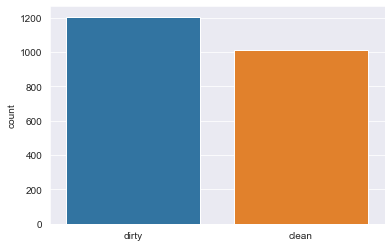

In [5]:
#visualisation to see if my dataset is balance
l = []
for i in df_train.label:
    if(i == 0):
        l.append("clean")
    else:
        l.append("dirty")
sns.set_style('darkgrid')
sns.countplot(l)

In [6]:
#one or the other I test
y_train = np.asarray(train_df['label']).astype('float32').reshape((-1,1))
y_test = np.asarray(test_df['label']).astype('float32').reshape((-1,1))

In [7]:
#convert to numpy array 
train = []
for i in range(len(train_df)):
    train.append(train_df['images'][i])
x_train = np.array(train)

test = []
for index, row in test_df.iterrows():
    test.append(row['images'])
x_test = np.array(test)

In [8]:
print("Shape of training data", x_train.shape)
print("\nShape of test data", x_test.shape)

Shape of training data (2217, 256, 256, 3)

Shape of test data (1195, 256, 256, 3)


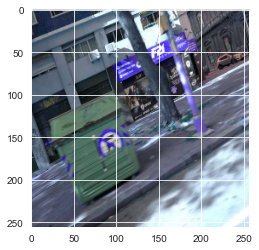

In [9]:
plt.imshow(x_train[630]) #example

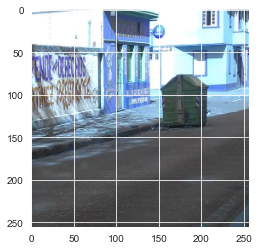

In [10]:
plt.imshow(x_test[61]) #example

## First Naive model

In [11]:
from keras import layers, models, optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array, load_img
from keras import layers, models, optimizers
from keras import backend as K
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), input_shape=(256, 256, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(32, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(64))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1))
model.add(layers.Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 254, 254, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      9248      
_________________________________________________________________
activation_1 (Activation)    (None, 125, 125, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        1

In [12]:
es = EarlyStopping(
    monitor="val_accuracy",
    patience=10
)

history = model.fit(
    x_train,
    y_train,
    batch_size=64,
    epochs=10,
    validation_data=(0.1*x_train, 0.1*y_train),callbacks=es
)

Epoch 1/10
35/35 [==============================] - 89s 2s/step - loss: 1.0510 - accuracy: 0.5313 - val_loss: 0.6869 - val_accuracy: 0.3406
Epoch 2/10
35/35 [==============================] - 64s 2s/step - loss: 0.6966 - accuracy: 0.5715 - val_loss: 0.6693 - val_accuracy: 0.3811
Epoch 3/10
35/35 [==============================] - 62s 2s/step - loss: 0.6560 - accuracy: 0.6189 - val_loss: 0.5984 - val_accuracy: 0.4556
Epoch 4/10
35/35 [==============================] - 61s 2s/step - loss: 0.6353 - accuracy: 0.6604 - val_loss: 0.4809 - val_accuracy: 0.4560
Epoch 5/10
35/35 [==============================] - 64s 2s/step - loss: 0.6259 - accuracy: 0.6743 - val_loss: 0.6488 - val_accuracy: 0.4560
Epoch 6/10
35/35 [==============================] - 68s 2s/step - loss: 0.5926 - accuracy: 0.6951 - val_loss: 0.5993 - val_accuracy: 0.4560
Epoch 7/10
35/35 [==============================] - 71s 2s/step - loss: 0.5757 - accuracy: 0.7077 - val_loss: 0.4091 - val_accuracy: 0.4560
Epoch 8/10
35/35 [==

## Predictions

In [13]:
y_pred = model.predict(x_test)
print(y_pred)

[[0.79618263]
 [0.87645364]
 [0.7753503 ]
 ...
 [0.25166664]
 [0.6380601 ]
 [0.40155095]]


dirty street by 100 % the prediction associate is [0.]


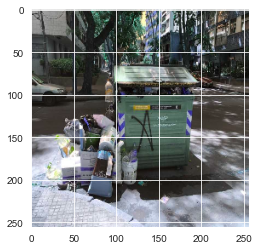

In [33]:
plt.imshow(x_test[1110])
pred = np.round(y_pred[1110],decimals=3)
if float(pred) > 0.5:
    print('clean street by', round(int(np.abs(100*pred)),1),'%','the prediction associate is',pred)
else:
    print('dirty street by', round(int(np.abs(100 - 100*pred)),1),'%','the prediction associate is',pred)

dirty street by 100 % the prediction associate is [0.]


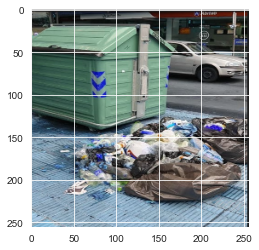

In [34]:
plt.imshow(x_test[900])
pred = np.round(y_pred[900],decimals=3)
if float(pred) > 0.5:
    print('clean street by', round(int(np.abs(100*pred)),1),'%','the prediction associate is',pred)
else:
    print('dirty street by', round(int(np.abs(100 - 100*pred)),1),'%','the prediction associate is',pred)

clean street by 100 % the prediction associate is [1.]


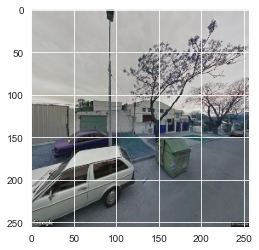

In [35]:
plt.imshow(x_test[10])
pred = np.round(y_pred[10],decimals=3)
if float(pred) > 0.5:
    print('clean street by', round(int(np.abs(100*pred)),1),'%','the prediction associate is',pred)
else:
    print('dirty street by', round(int(np.abs(100 - 100*pred)),1),'%','the prediction associate is',pred)

clean street by 30 % the prediction associate is [0.691]


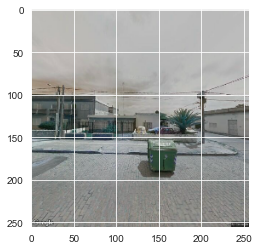

In [17]:
plt.imshow(x_test[3])
pred = np.round(y_pred[3],decimals=3)
if float(pred) > 0.5:
    print('clean street by', round(int(np.abs(100*pred)),1),'%','the prediction associate is',pred)
else:
    print('dirty street by', round(int(np.abs(100 - 100*pred)),1),'%','the prediction associate is',pred)

## Evaluation the result

In [18]:
print(y_pred[900],y_test[900])

[0.00257009] [0.]


In [19]:
#change y_pred to binary array
for i in range(len(y_pred)):
    if y_pred[i] < 0.5:
        y_pred[i] = 0
    else:
        y_pred[i] = 1

In [20]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

array([[431, 164],
       [128, 472]])

In [21]:
print('Thats mean that we have', cm[0,0], 'true positive', cm[0,1], 'false positive', cm[1,0], 'false positive and', cm[1,1], 'true negative, well done!')

Thats mean that we have 431 true positive 164 false positive 128 false positive and 472 true negative, well done!


In [22]:
#Accuracy
from sklearn.metrics import accuracy_score
print('accuracy score',accuracy_score(y_test, y_pred))
# Recall
from sklearn.metrics import recall_score
print('recall score',recall_score(y_test, y_pred))
# Precision
from sklearn.metrics import precision_score
print('precision score',precision_score(y_test, y_pred))
from sklearn.metrics import f1_score
print('f1 score',f1_score(y_test, y_pred))

accuracy score 0.7556485355648536
recall score 0.7866666666666666
precision score 0.7421383647798742
f1 score 0.7637540453074433


# Task 2: Network interpretation:
Localize garbage/waste in dirty image scenes using only image-level information using Class Activation Maps.<br>

* Consider visualizing the activation maps in several convolutional layers 

In [23]:
from tensorflow.keras.models import Model

def GradCam(model, img_array, layer_name, eps=1e-8):
    gradModel = Model(
            inputs=[model.inputs],
            outputs=[model.get_layer(layer_name).output,
            model.output])
    
    with tf.GradientTape() as tape:
      inputs = tf.cast(img_array, tf.float32)
      (convOutputs, predictions) = gradModel(inputs)
      loss = predictions[:, 0]
    grads = tape.gradient(loss, convOutputs)
    
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
  
    (w, h) = (img_array.shape[2], img_array.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    return heatmap


def sigmoid(x, a, b, c):
    return c / (1 + np.exp(-a * (x-b)))

def superimpose(img_bgr, cam, thresh, emphasize=False):
    heatmap = cv2.resize(cam, (img_bgr.shape[1], img_bgr.shape[0]))
    if emphasize:
        heatmap = sigmoid(heatmap, 50, thresh, 1)
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    hif = .8
    superimposed_img = heatmap * hif + img_bgr
    superimposed_img = np.minimum(superimposed_img, 255.0).astype(np.uint8)  # scale 0 to 255  
    superimposed_img_rgb = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
    
    return superimposed_img_rgb

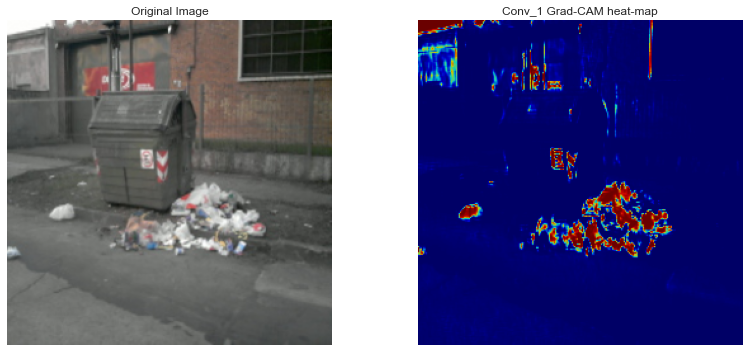

In [24]:
## Grad-CAM heatmap for the last convolutional layer in the model, Conv_1
layer_name = 'conv2d'
grad_cam=GradCam(model,np.expand_dims(image, axis=0),layer_name)
grad_cam_superimposed = superimpose(image, grad_cam, 0.5, emphasize=True)

plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 2, 2)
plt.imshow(grad_cam_superimposed)
plt.axis('off')
plt.title('Conv_1 Grad-CAM heat-map')
plt.tight_layout()

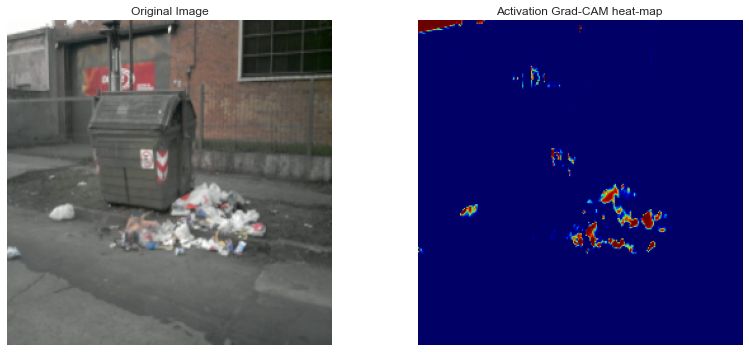

In [25]:
## Grad-CAM heatmap for the last convolutional layer in the model, Conv_1
layer_name = 'activation'
grad_cam=GradCam(model,np.expand_dims(image, axis=0),layer_name)
grad_cam_superimposed = superimpose(image, grad_cam, 0.5, emphasize=True)

plt.figure(figsize=(12, 5))
ax = plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 2, 2)
plt.imshow(grad_cam_superimposed)
plt.axis('off')
plt.title('Activation Grad-CAM heat-map')
plt.tight_layout()

In [26]:
## Gather all convolution and activation layers from the model
## With these layers, we can explore grad-cam heatmaps for more layers in the model

conv2D_layers = [layer.name for layer in reversed(model.layers) if len(layer.output_shape) == 4 and isinstance(layer, tf.keras.layers.Conv2D)]
activation_layers = [layer.name for layer in reversed(model.layers) if len(layer.output_shape) == 4 and isinstance(layer, tf.keras.layers.Activation)]
maxpooling_layers = [layer.name for layer in reversed(model.layers) if len(layer.output_shape) == 4 and isinstance(layer, tf.keras.layers.MaxPooling2D)]
all_layers = [layer.name for layer in reversed(model.layers) if len(layer.output_shape) == 4 and (isinstance(layer, tf.keras.layers.MaxPooling2D) or isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.Activation))]

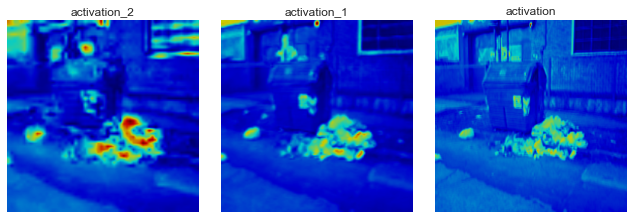

In [27]:
## Visualizing Activation layers
plt.figure(figsize=(15, 20))
for i, layer in enumerate(activation_layers):
  grad_cam = GradCam(model, np.expand_dims(image, axis=0), layer)
  grad_cam_emphasized = superimpose(image, grad_cam, 0.5, emphasize=False)
  ax = plt.subplot(7, 5, i +1)
  plt.imshow(grad_cam_emphasized)
  plt.title(layer)
  plt.axis("off")
plt.tight_layout()

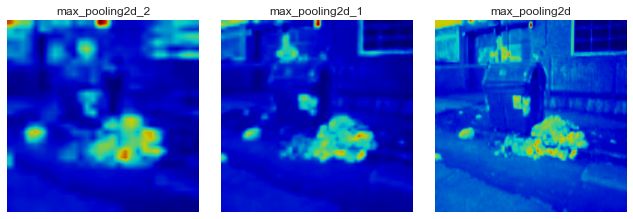

In [28]:
## Visualizing Activation layers
plt.figure(figsize=(15, 20))
for i, layer in enumerate(maxpooling_layers):
  grad_cam = GradCam(model, np.expand_dims(image, axis=0), layer)
  grad_cam_emphasized = superimpose(image, grad_cam, 0.5, emphasize=False)
  ax = plt.subplot(7, 5, i +1)
  plt.imshow(grad_cam_emphasized)
  plt.title(layer)
  plt.axis("off")
plt.tight_layout()

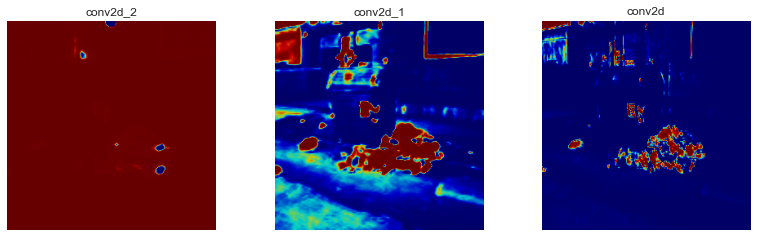

In [29]:
## Visualizing Convolution layers
plt.figure(figsize=(15, 40))
for i, layer in enumerate(conv2D_layers):
  grad_cam = GradCam(model, np.expand_dims(image, axis=0), layer)
  grad_cam_emphasized = superimpose(image, grad_cam, 0.5, emphasize=True)
  ax = plt.subplot(13, 4, i +1)
  plt.imshow(grad_cam_emphasized)
  plt.title(layer)
  plt.axis("off")
plt.tight_layout()

In [30]:
def fuse_layers(layers, model, img, emphasize=False):
  cams = []
  for layer in layers:
    cam = GradCam(model, np.expand_dims(img, axis=0), layer)
    cam = cv2.resize(cam, (img.shape[1], img.shape[0]))
    cams.append(cam)
  fused = np.mean(cams, axis=0)
  superimposed = superimpose(img, fused, 0.5, emphasize=emphasize)
  return superimposed

In [31]:
## Using the fuse_layers function, lets fuse together all layers in the model
fused = fuse_layers(all_layers, model, image, True)

Text(0.5, 1.0, 'All layers Grad-CAM heat-map')

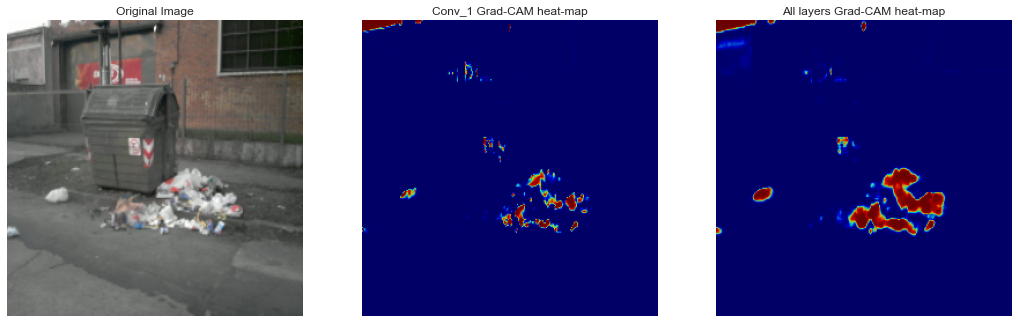

In [32]:
## We can see how fusing together all layers improves upon the Grad-CAM from the last
## convolutional layer in the model
plt.figure(figsize=(18, 8))
ax = plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Original Image')
ax = plt.subplot(1, 3, 2)
plt.imshow(grad_cam_superimposed)
plt.axis('off')
plt.title('Conv_1 Grad-CAM heat-map')
ax = plt.subplot(1, 3, 3)
plt.imshow(fused)
plt.axis('off')
plt.title('All layers Grad-CAM heat-map')

# Task 3: Clean dirty city images

For this, use Cycle GAN and train it to clean dirty streets (remove the waste from images). <br>
* You will create one two-fold model: one that removes waste, one that adds it.
* You will need two sets of images, one with and one without waste. 
* Visualize success and failure cases 


At first glance, the architecture of the CycleGAN appears complex. Let’s take a moment to step through all of the models involved and their inputs and outputs.
Consider the problem where we are interested in translating images from dirty to clean and clean to dirty.

We have two collections of photographs and they are unpaired, meaning they are photos of different locations at different times; we don’t have the exact same scenes in clean and dirty.

Collection 1: Photos of dirty landscapes.
Collection 2: Photos of clean landscapes.
We will develop an architecture of two GANs, and each GAN has a discriminator and a generator model, meaning there are four models in total in the architecture.

The first GAN will generate photos of clean given photos of dirty, and the second GAN will generate photos of dirty given photos of clean.

GAN 1: Translates photos of dirty (collection 1) to clean (collection 2).
GAN 2: Translates photos of clean (collection 2) to dirty (collection 1).
Each GAN has a conditional generator model that will synthesize an image given an input image. And each GAN has a discriminator model to predict how likely the generated image is to have come from the target image collection. The discriminator and generator models for a GAN are trained under normal adversarial loss like a standard GAN model.

We can summarize the generator and discriminator models from GAN 1 as follows:

**Generator Model 1**:
* Input: Takes photos of dirty (collection 1).
* Output: Generates photos of clean (collection 2).
**Discriminator Model 1**:
* Input: Takes photos of clean from collection 2 and output from Generator Model 1.
*  Output: Likelihood of image is from collection 2.<br>
Similarly, we can summarize the generator and discriminator models from GAN 2 as follows:

**Generator Model 2**:
* Input: Takes photos of clean (collection 2).
* Output: Generates photos of dirty (collection 1).
**Discriminator Model 2**:
* Input: Takes photos of dirty from collection 1 and output from Generator Model 2.
* Output: Likelihood of image is from collection 1.<br>
So far, the models are sufficient for generating plausible images in the target domain but are not translations of the input image.

Each of the GANs are also updated using cycle consistency loss. This is designed to encourage the synthesized images in the target domain that are translations of the input image.

Cycle consistency loss compares an input photo to the Cycle GAN to the generated photo and calculates the difference between the two, e.g. using the L1 norm or summed absolute difference in pixel values.

There are two ways in which cycle consistency loss is calculated and used to update the generator models each training iteration.

The first GAN (GAN 1) will take an image of a dirty landscape, generate image of a clean landscape, which is provided as input to the second GAN (GAN 2), which in turn will generate an image of a dirty landscape. The cycle consistency loss calculates the difference between the image input to GAN 1 and the image output by GAN 2 and the generator models are updated accordingly to reduce the difference in the images.

This is a forward-cycle for cycle consistency loss. The same process is related in reverse for a backward cycle consistency loss from generator 2 to generator 1 and comparing the original photo of clean to the generated photo of clean.

**Forward Cycle Consistency Loss**:
* Input photo of dirty (collection 1) to GAN 1
* Output photo of clean from GAN 1
* Input photo of clean from GAN 1 to GAN 2
* Output photo of dirty from GAN 2
* Compare photo of dirty (collection 1) to photo of dirty from GAN 2
**Backward Cycle Consistency Loss**:
* Input photo of clean (collection 2) to GAN 2
* Output photo of dirty from GAN 2
* Input photo of dirty from GAN 2 to GAN 1
* Output photo of clean from GAN 1
* Compare photo of clean (collection 2) to photo of clean from GAN 1